# FaIR with input data
## Learning out how to run FaIR with input data. Creating a dummy input dataset to learn formatting
## Created 01/22/2024




In [241]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

### Create instance

In [215]:
f = FAIR(ghg_method='leach2021')

### Define time horizon

In [216]:
# reconstruct hist
f.define_time(1970, 2023, 1)

### Define scenarios

In [217]:
f.define_scenarios(['test1'])

### Define configs

In [218]:
f.define_configs(['config1'])

### Define species

In [219]:
# going to try just CO2 to start
species = ['CO2']

In [220]:
properties = {
    'CO2': {
        'type': 'co2',
        'input_mode': 'emissions',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False,
    }}

In [221]:
properties

{'CO2': {'type': 'co2',
  'input_mode': 'emissions',
  'greenhouse_gas': True,
  'aerosol_chemistry_from_emissions': False,
  'aerosol_chemistry_from_concentration': False}}

In [222]:
f.define_species(species, properties)

### Create input and output data

In [223]:
# create empty emission and temp arrays
f.allocate()   

In [224]:
f.emissions

<xarray.DataArray (timepoints: 53, scenario: 1, config: 1, specie: 1)>
array([[[[nan]]],


       [[[nan]]],


       [[[nan]]],


       [[[nan]]],


       [[[nan]]],


       [[[nan]]],


       [[[nan]]],

...

       [[[nan]]],


       [[[nan]]],


       [[[nan]]],


       [[[nan]]],


       [[[nan]]],


       [[[nan]]],


       [[[nan]]]])
Coordinates:
  * timepoints  (timepoints) float64 1.97e+03 1.972e+03 ... 2.022e+03 2.022e+03
  * scenario    (scenario) <U5 'test1'
  * config      (config) <U7 'config1'
  * specie      (specie) <U3 'CO2'

In [225]:
f.temperature

<xarray.DataArray (timebounds: 54, scenario: 1, config: 1, layer: 3)>
array([[[[nan, nan, nan]]],


       [[[nan, nan, nan]]],


       [[[nan, nan, nan]]],


       [[[nan, nan, nan]]],


       [[[nan, nan, nan]]],


       [[[nan, nan, nan]]],


       [[[nan, nan, nan]]],

...

       [[[nan, nan, nan]]],


       [[[nan, nan, nan]]],


       [[[nan, nan, nan]]],


       [[[nan, nan, nan]]],


       [[[nan, nan, nan]]],


       [[[nan, nan, nan]]],


       [[[nan, nan, nan]]]])
Coordinates:
  * timebounds  (timebounds) float64 1.97e+03 1.971e+03 ... 2.022e+03 2.023e+03
  * scenario    (scenario) <U5 'test1'
  * config      (config) <U7 'config1'
  * layer       (layer) int64 0 1 2

### Fill in the data
1. emissions/concentrations
2. climate_configs
3. species_configs

#### emissions/concentrations

In [226]:
co2_data = pd.read_csv("IEA_EDGAR_CO2_1970_2022.csv", index_col="Year")

In [227]:
co2_data

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Year,,,,,,,,,,,,,,,,,,,,,
CO2 Emissions,15825428,15791981,16595636,17571714,17501571,17450419,18448008,19008075,19508790,20047750,...,36066771,36290322,36158867,36256053,36890306,37831881,37824922,35944484,38082177,38522011


In [228]:
co2_np = co2_data.to_numpy()
co2_np

array([[15825428, 15791981, 16595636, 17571714, 17501571, 17450419,
        18448008, 19008075, 19508790, 20047750, 19788048, 19422676,
        19169208, 19307241, 19926542, 20185812, 20541712, 21190601,
        21946997, 22333218, 22516776, 22654819, 22564265, 22672047,
        22891595, 23558161, 24014919, 24484309, 24642505, 24821891,
        25621005, 25938844, 26344013, 27562255, 28846464, 29924600,
        30943465, 32112597, 32307311, 31897679, 33848414, 34911315,
        35380008, 36066771, 36290322, 36158867, 36256053, 36890306,
        37831881, 37824922, 35944484, 38082177, 38522011]])

In [229]:
print(co2_np.shape)
print(f.emissions.shape)

(1, 53)
(53, 1, 1, 1)


In [230]:
# need to reshape to fit emissions df
co2_np = np.reshape(co2_np, (53,1))
co2_np.shape

(53, 1)

In [231]:
fill(f.emissions, co2_np, scenario='test1', specie='CO2')

In [232]:
# initial conditions
initialise(f.concentration, 325, specie='CO2')   # taken from EU EEA
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

#### climate configs

In [233]:
f.climate_configs

<xarray.Dataset>
Dimensions:                (config: 1, layer: 3)
Coordinates:
  * config                 (config) <U7 'config1'
  * layer                  (layer) int64 0 1 2
Data variables:
    ocean_heat_transfer    (config, layer) float64 nan nan nan
    ocean_heat_capacity    (config, layer) float64 nan nan nan
    deep_ocean_efficacy    (config) float64 nan
    stochastic_run         (config) bool False
    sigma_eta              (config) float64 0.5
    sigma_xi               (config) float64 0.5
    gamma_autocorrelation  (config) float64 2.0
    seed                   (config) uint32 0
    use_seed               (config) bool False
    forcing_4co2           (config) float64 8.0

In [234]:
fill(f.climate_configs["ocean_heat_transfer"], [1.1, 1.6, 0.9], config='config1')
fill(f.climate_configs["ocean_heat_capacity"], [8, 14, 100], config='config1')
fill(f.climate_configs["deep_ocean_efficacy"], 1.1, config='config1')

In [235]:
f.climate_configs

<xarray.Dataset>
Dimensions:                (config: 1, layer: 3)
Coordinates:
  * config                 (config) <U7 'config1'
  * layer                  (layer) int64 0 1 2
Data variables:
    ocean_heat_transfer    (config, layer) float64 1.1 1.6 0.9
    ocean_heat_capacity    (config, layer) float64 8.0 14.0 100.0
    deep_ocean_efficacy    (config) float64 1.1
    stochastic_run         (config) bool False
    sigma_eta              (config) float64 0.5
    sigma_xi               (config) float64 0.5
    gamma_autocorrelation  (config) float64 2.0
    seed                   (config) uint32 0
    use_seed               (config) bool False
    forcing_4co2           (config) float64 8.0

#### species configs

In [236]:
f.fill_species_configs()

In [237]:
f.species_configs

<xarray.Dataset>
Dimensions:                                   (config: 1, specie: 1, gasbox: 4)
Coordinates:
  * config                                    (config) <U7 'config1'
  * specie                                    (specie) <U3 'CO2'
  * gasbox                                    (gasbox) int64 0 1 2 3
Data variables: (12/31)
    tropospheric_adjustment                   (config, specie) float64 0.05
    forcing_efficacy                          (config, specie) float64 1.0
    forcing_temperature_feedback              (config, specie) float64 0.0
    forcing_scale                             (config, specie) float64 1.0
    partition_fraction                        (config, specie, gasbox) float64 ...
    unperturbed_lifetime                      (config, specie, gasbox) float64 ...
    ...                                        ...
    aci_shape                                 (config, specie) float64 0.0
    cl_atoms                                  (specie) float64 0.0
    br_atoms                                  (specie) float64 0.0
    fractional_release                        (config, specie) float64 0.0
    ch4_lifetime_chemical_sensitivity         (config, specie) float64 0.0
    lifetime_temperature_sensitivity          (config) float64 -0.0408

### Run

In [238]:
f.run()

Running 1 projections in parallel:   0%|          | 0/53 [00:00<?, ?timesteps/s]

In [243]:
f.timebounds

array([1970., 1971., 1972., 1973., 1974., 1975., 1976., 1977., 1978.,
       1979., 1980., 1981., 1982., 1983., 1984., 1985., 1986., 1987.,
       1988., 1989., 1990., 1991., 1992., 1993., 1994., 1995., 1996.,
       1997., 1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005.,
       2006., 2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014.,
       2015., 2016., 2017., 2018., 2019., 2020., 2021., 2022., 2023.])

Text(0, 0.5, 'Temperature anomaly (K)')

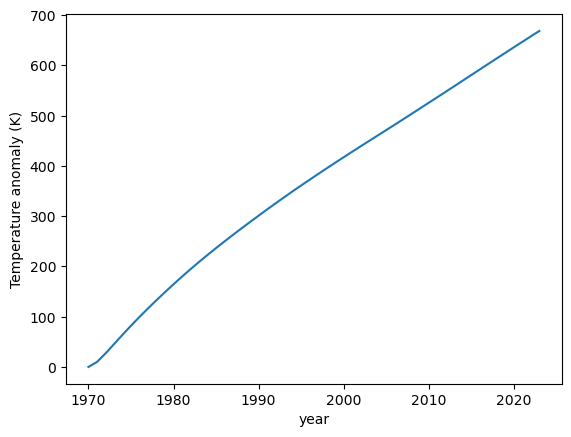

In [258]:
plt.plot(f.timebounds, f.temperature.loc[dict(scenario='test1', layer=0)])
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')